# Word Embeddings

## Loading Datasets & Importing Modules

In [1]:
import sys
import os
sys.path.append('./Files')
sys.path.append('./Datasets')

In [2]:
os.system('pip install nltk')

0

In [3]:
os.system('pip install gensim')

0

In [4]:
import nltk
import gensim
from gensim.models import Word2Vec
import pandas as pd
from dataCleaner import preProcess
import numpy as np
import matplotlib.pyplot as plt
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20122\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [6]:
df_train = pd.read_csv('Datasets/merged_train_datasets.csv')

## Word2Vec

### Preparing Data

In [7]:
preProcess(df_train)
df_train.head()

,Unnamed: 0,tweet,sentiment
0,1,اهنئ احمد جمال دين قيادي بحزب مصر بمناسب صدر ر...,positive
1,2,برادعي يستقو بامريكا مرهاخر يرسل عصام عريان اش...,negative
2,4,والده اقول بخاطر حشيش تضحك بس اقول كيلك تعطين ...,neutral
3,5,انتخبوا العرص انتخبوا البرص مرسي رئيس اين رئيس...,neutral
4,6,يتقال ستريكر صريح كاريوك السكه شمال,positive


In [8]:
tweets = []
for i in df_train['tweet']:
    tweet = nltk.word_tokenize(i)
    tweets.append(tweet)

### CBOW

In [9]:
flat_tweets = [item for sublist in tweets for item in sublist]

In [10]:
vocab = set(flat_tweets)

In [11]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

In [12]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [14]:
data = []
for i in range(2, len(flat_tweets) - 2):
    context = [flat_tweets[i - 2], flat_tweets[i - 1], flat_tweets[i + 1], flat_tweets[i + 2]]
    target = flat_tweets[i]
    data.append((context, target))

In [15]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

In [16]:
def linear(m, theta):
    w = theta
    return m.dot(w)

def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [17]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [18]:
epoch_losses = {}

for epoch in range(30):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

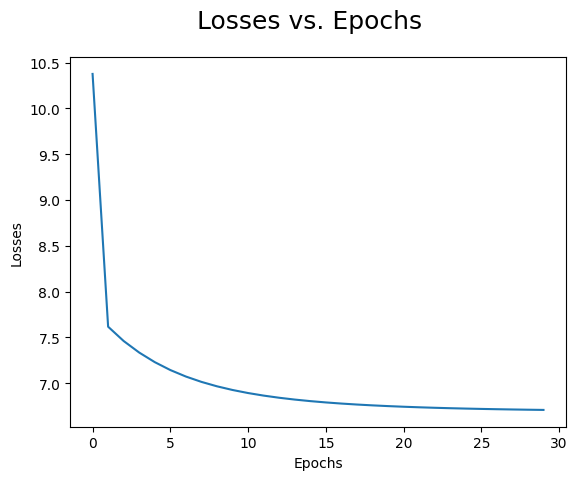

In [19]:
ix = np.arange(0,30)

fig = plt.figure()
fig.suptitle('Losses vs. Epochs', fontsize=18)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Losses', fontsize=10)

In [20]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

### Skip-Gram

## GloVe